# Entendendo o Mecanismo de Atenção no Transformer
Este notebook explica passo a passo como funciona o cálculo do mecanismo de Atenção Escalar e Multi-Head Attention no Transformer.

Vamos construir um exemplo simples, ilustrando matematicamente e visualmente o processo de atenção.

In [ ]:
# Instalação (se necessário)
!pip install numpy matplotlib torch

## 1. Importação das bibliotecas necessárias

In [9]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## 2. Função de Atenção Escalar
Implementando a fórmula:

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

In [10]:
def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, V)
    return output, attn

## 3. Exemplo de Atenção Escalar
Criamos vetores simples para entender os cálculos.

In [11]:
Q = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
K = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
V = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)

output, attn = scaled_dot_product_attention(Q, K, V)

print('Output:', output)
print('Attention Weights:', attn)

Output: tensor([[0.6698, 0.3302],
        [0.3302, 0.6698]])
Attention Weights: tensor([[0.6698, 0.3302],
        [0.3302, 0.6698]])


## 4. Visualizando os Pesos de Atenção

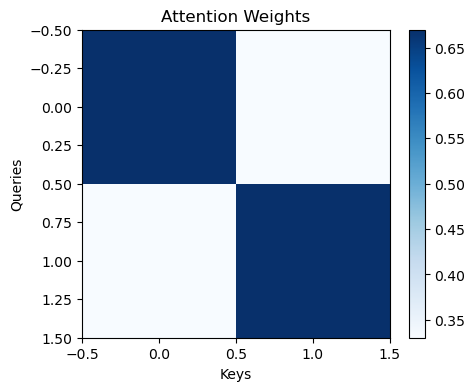

In [12]:
plt.figure(figsize=(5, 4))
plt.title('Attention Weights')
plt.imshow(attn.detach().numpy(), cmap='Blues')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.colorbar()
plt.show()

## 5. Implementando Multi-Head Attention Manualmente
Dividimos os vetores em múltiplas cabeças e aplicamos atenção em paralelo.

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        output, attn = scaled_dot_product_attention(Q, K, V)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        return self.out(output), attn

## 6. Exemplo com Multi-Head Attention

In [14]:
embed_dim = 4
num_heads = 2

mha = MultiHeadAttention(embed_dim, num_heads)

x = torch.rand(1, 3, embed_dim)  # (batch, seq_len, embed_dim)
output, attn = mha(x, x, x)

print('Output:', output)
print('Attention shape:', attn.shape)

Output: tensor([[[-0.4658,  0.5896,  0.5650, -0.1854],
         [-0.4690,  0.5917,  0.5664, -0.1876],
         [-0.4700,  0.5921,  0.5666, -0.1882]]], grad_fn=<ViewBackward0>)
Attention shape: torch.Size([1, 2, 3, 3])


In [ ]:
# Suponha que temos uma sentença simulada
tokens = ["eu", "gosto", "de", "IA"]

# Para manter o exemplo coerente, vamos gerar tensores alinhados ao número de tokens
seq_len = len(tokens)
embed_dim = 4
num_heads = 2

# Criando uma instância de Multi-Head Attention
mha = MultiHeadAttention(embed_dim, num_heads)

# Criando embeddings simulados para a sentença
x = torch.rand(1, seq_len, embed_dim)  # (batch, seq_len, embed_dim)

# Executando atenção
output, attn = mha(x, x, x)  # attn shape: (batch, num_heads, seq_len, seq_len)

# Selecionando a primeira cabeça de atenção
attn_matrix = attn[0, 0].detach().numpy()  # (seq_len, seq_len)

# Plotando a matriz de atenção com rótulos
plt.figure(figsize=(6, 5))
plt.title('Mapa de Atenção (Cabeça 1)')
plt.imshow(attn_matrix, cmap='Blues')

plt.xticks(ticks=range(seq_len), labels=tokens)
plt.yticks(ticks=range(seq_len), labels=tokens)

plt.xlabel('Keys')
plt.ylabel('Queries')

plt.colorbar(label="Peso de Atenção")
plt.show()